In [1]:
import pandas as pd
import dask.dataframe as dd
from sklearn.decomposition import KernelPCA
import numpy as np
from scipy.signal import periodogram
import statsmodels.api as sm
import scipy
import requests

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
rename_col = {"sub_region_1":"state", "retail_and_recreation_percent_change_from_baseline":"retail",
              "grocery_and_pharmacy_percent_change_from_baseline":"grocery", "parks_percent_change_from_baseline":"parks",
              "transit_stations_percent_change_from_baseline":"transit", "workplaces_percent_change_from_baseline":"work",
              "residential_percent_change_from_baseline":"resident"}
df_all = pd.read_csv('US_Region_Mobility_Report_cleaned.csv')
df_all = df_all.rename(columns=rename_col)
df_all.head()

,date,state,retail,grocery,parks,transit,work,resident
0,2020-02-15,Alabama,5.0,2.0,39.0,7.0,2.0,-1.0
1,2020-02-15,Alaska,5.0,3.0,14.0,2.0,1.0,0.0
2,2020-02-15,Arizona,3.0,2.0,13.0,3.0,-1.0,0.0
3,2020-02-15,Arkansas,3.0,2.0,8.0,-3.0,1.0,0.0
4,2020-02-15,California,1.0,1.0,19.0,1.0,-1.0,0.0


In [3]:
NY_data = df_all[df_all['state']=='New York'].reset_index()
NY_data.head()

,index,date,state,retail,grocery,parks,transit,work,resident
0,32,2020-02-15,New York,3.0,-4.0,-2.0,-4.0,1.0,0.0
1,83,2020-02-16,New York,7.0,-3.0,13.0,0.0,0.0,-1.0
2,134,2020-02-17,New York,7.0,-2.0,23.0,-22.0,-37.0,9.0
3,185,2020-02-18,New York,-2.0,-5.0,-4.0,-5.0,-10.0,3.0
4,236,2020-02-19,New York,3.0,-2.0,11.0,-3.0,-9.0,2.0


In [4]:
df_covid = pd.read_csv('covid_df_cleaned.csv')
df_covid['Covid_Date'] = pd.to_datetime(df_covid['Covid_Date'])
df_covid['Covid_Date'] = df_covid['Covid_Date'].dt.date
df_covid = df_covid[['Province_State','Covid_Date','Confirmed']]
NY_covid = df_covid[df_covid['Province_State']=='New York'].reset_index()
NY_covid.head()

,index,Province_State,Covid_Date,Confirmed
0,22784,New York,2020-04-12,189033
1,22785,New York,2020-04-13,195749
2,22786,New York,2020-04-14,203020
3,22787,New York,2020-04-15,214454
4,22788,New York,2020-04-16,223691


In [5]:
NY_data['date'] = pd.to_datetime(NY_data['date'])
NY_covid['Covid_Date'] = pd.to_datetime(NY_covid['Covid_Date'])
NY_covid = NY_covid.rename(columns={"Covid_Date":"date"})
df_NY = NY_data.merge(NY_covid, how='inner', on='date')
df_NY.set_index(df_NY['date'], inplace=True)
df_NY = df_NY.drop(columns=['date','index_x','state','index_y','Province_State'])
df_NY['confirmed'] = df_NY['Confirmed'].diff()
df_NY = df_NY.drop(columns=['Confirmed'])
df_NY.head()

,retail,grocery,parks,transit,work,resident,confirmed
date,,,,,,,
2020-04-12,-75.0,-44.0,-10.0,-68.0,-51.0,15.0,NaN
2020-04-13,-70.0,-39.0,-59.0,-76.0,-64.0,29.0,6716.0
2020-04-14,-60.0,-19.0,-15.0,-68.0,-61.0,26.0,7271.0
2020-04-15,-59.0,-20.0,-25.0,-69.0,-61.0,27.0,11434.0
2020-04-16,-61.0,-20.0,-35.0,-70.0,-61.0,27.0,9237.0


In [6]:
df_NY_a = df_NY['2020-07-01':'2020-09-30']
df_NY_a.tail()

,retail,grocery,parks,transit,work,resident,confirmed
date,,,,,,,
2020-09-26,-19.0,-4.0,84.0,-32.0,-13.0,2.0,1000.0
2020-09-27,-19.0,-9.0,79.0,-34.0,-15.0,2.0,1173.0
2020-09-28,-22.0,-9.0,25.0,-47.0,-41.0,11.0,1032.0
2020-09-29,-26.0,-9.0,-9.0,-45.0,-36.0,11.0,969.0
2020-09-30,-22.0,-4.0,14.0,-44.0,-36.0,11.0,979.0


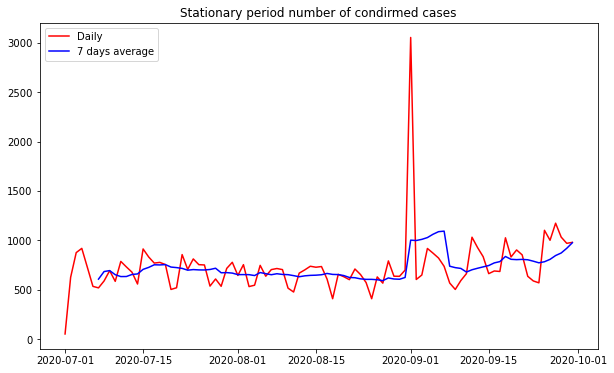

In [27]:
plt.figure(figsize = (10,6))
plt.title('Stationary period number of condirmed cases')
plt.plot(df_NY_a.index,df_NY_a.confirmed, label = 'Daily', color = 'red')
plt.plot(df_NY_a.index,df_NY_a.confirmed.rolling(window = 7).mean(), label = '7 days average', color = 'blue')
plt.legend(loc="upper left")

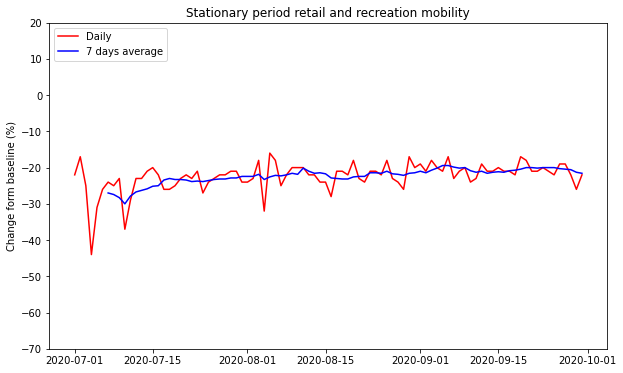

In [26]:
plt.figure(figsize = (10,6))
plt.title('Stationary period retail and recreation mobility')
plt.ylabel('Change form baseline (%)')
plt.ylim(-70,20)
plt.plot(df_NY_a.index,df_NY_a.retail, label = 'Daily', color = 'red')
plt.plot(df_NY_a.index,df_NY_a.retail.rolling(window = 7).mean(), label = '7 days average', color = 'blue')
plt.legend(loc="upper left")

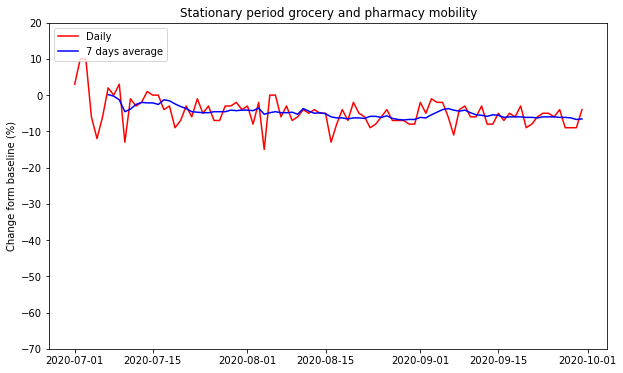

In [28]:
plt.figure(figsize = (10,6))
plt.title('Stationary period grocery and pharmacy mobility')
plt.ylabel('Change form baseline (%)')
plt.ylim(-70,20)
plt.plot(df_NY_a.index,df_NY_a.grocery, label = 'Daily', color = 'red')
plt.plot(df_NY_a.index,df_NY_a.grocery.rolling(window = 7).mean(), label = '7 days average', color = 'blue')
plt.legend(loc="upper left")

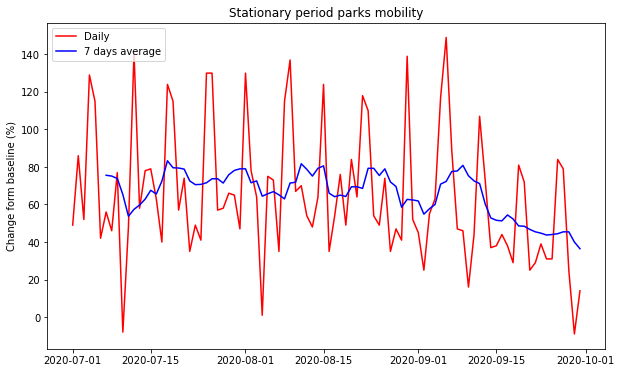

In [29]:
plt.figure(figsize = (10,6))
plt.title('Stationary period parks mobility')
plt.ylabel('Change form baseline (%)')
plt.plot(df_NY_a.index,df_NY_a.parks, label = 'Daily', color = 'red')
plt.plot(df_NY_a.index,df_NY_a.parks.rolling(window = 7).mean(), label = '7 days average', color = 'blue')
plt.legend(loc="upper left")

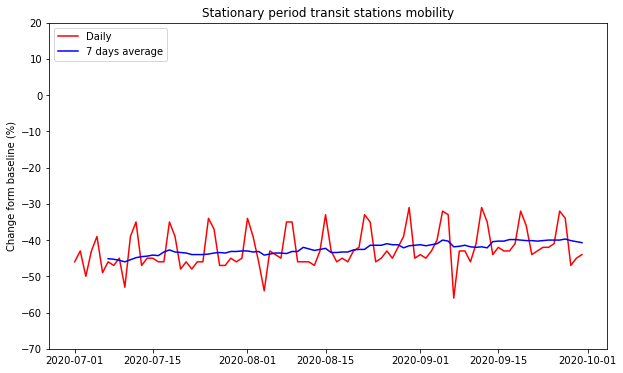

In [30]:
plt.figure(figsize = (10,6))
plt.title('Stationary period transit stations mobility')
plt.ylabel('Change form baseline (%)')
plt.ylim(-70,20)
plt.plot(df_NY_a.index,df_NY_a.transit, label = 'Daily', color = 'red')
plt.plot(df_NY_a.index,df_NY_a.transit.rolling(window = 7).mean(), label = '7 days average', color = 'blue')
plt.legend(loc="upper left")

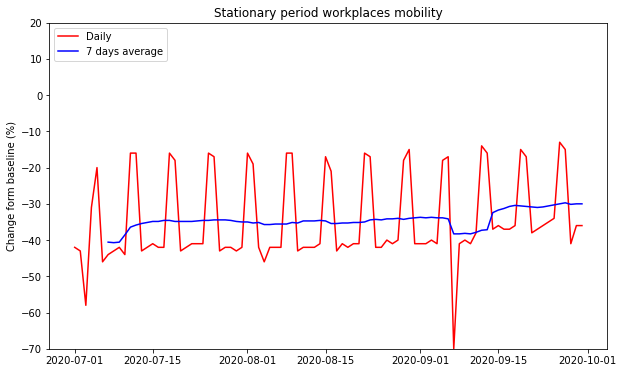

In [31]:
plt.figure(figsize = (10,6))
plt.title('Stationary period workplaces mobility')
plt.ylabel('Change form baseline (%)')
plt.ylim(-70,20)
plt.plot(df_NY_a.index,df_NY_a.work, label = 'Daily', color = 'red')
plt.plot(df_NY_a.index,df_NY_a.work.rolling(window = 7).mean(), label = '7 days average', color = 'blue')
plt.legend(loc="upper left")

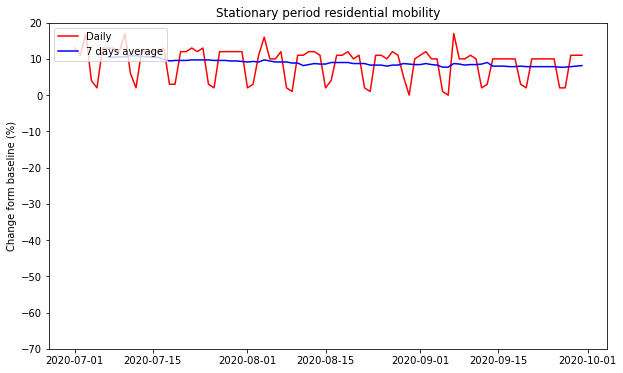

In [39]:
plt.figure(figsize = (10,6))
plt.title('Stationary period residential mobility')
plt.ylabel('Change form baseline (%)')
plt.ylim(-70,20)
plt.plot(df_NY_a.index,df_NY_a.resident, label = 'Daily', color = 'red')
plt.plot(df_NY_a.index,df_NY_a.resident.rolling(window = 7).mean(), label = '7 days average', color = 'blue')
plt.legend(loc="upper left")

In [14]:
df_NY_b = df_NY['2021-12-15':'2022-02-08']
df_NY_b.head()

,retail,grocery,parks,transit,work,resident,confirmed
date,,,,,,,
2021-12-15,-10.0,3.0,-2.0,-27.0,-25.0,7.0,8849.0
2021-12-16,-7.0,5.0,12.0,-27.0,-24.0,6.0,12680.0
2021-12-17,-12.0,2.0,1.0,-28.0,-26.0,7.0,17904.0
2021-12-18,-14.0,-3.0,-10.0,-26.0,-13.0,4.0,20897.0
2021-12-19,-8.0,-4.0,0.0,-23.0,-13.0,3.0,14087.0


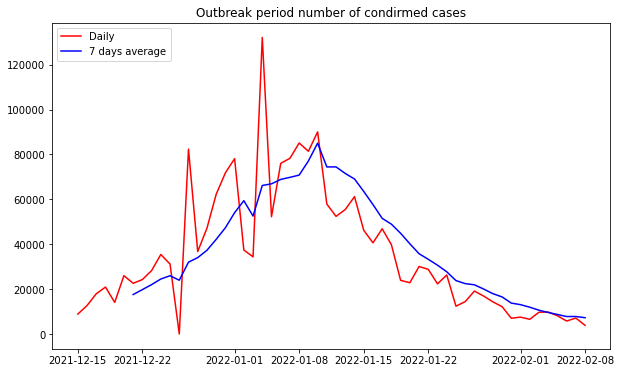

In [33]:
plt.figure(figsize = (10,6))
plt.title('Outbreak period number of condirmed cases')
plt.plot(df_NY_b.index,df_NY_b.confirmed, label = 'Daily', color = 'red')
plt.plot(df_NY_b.index,df_NY_b.confirmed.rolling(window = 7).mean(), label = '7 days average', color = 'blue')
plt.legend(loc="upper left")

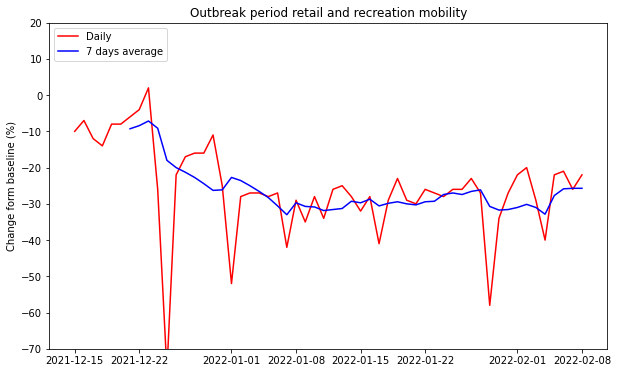

In [34]:
plt.figure(figsize = (10,6))
plt.title('Outbreak period retail and recreation mobility')
plt.ylabel('Change form baseline (%)')
plt.ylim(-70,20)
plt.plot(df_NY_b.index,df_NY_b.retail, label = 'Daily', color = 'red')
plt.plot(df_NY_b.index,df_NY_b.retail.rolling(window = 7).mean(), label = '7 days average', color = 'blue')
plt.legend(loc="upper left")

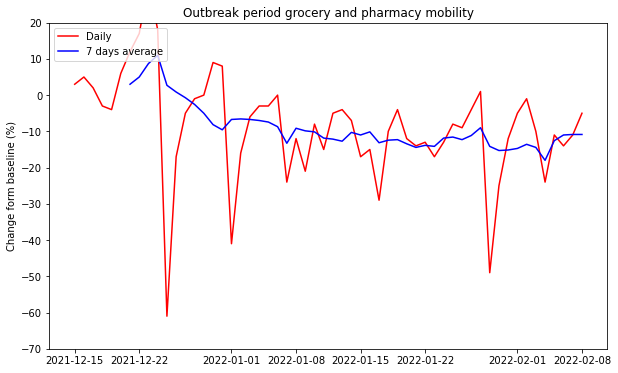

In [35]:
plt.figure(figsize = (10,6))
plt.title('Outbreak period grocery and pharmacy mobility')
plt.ylabel('Change form baseline (%)')
plt.ylim(-70,20)
plt.plot(df_NY_b.index,df_NY_b.grocery, label = 'Daily', color = 'red')
plt.plot(df_NY_b.index,df_NY_b.grocery.rolling(window = 7).mean(), label = '7 days average', color = 'blue')
plt.legend(loc="upper left")

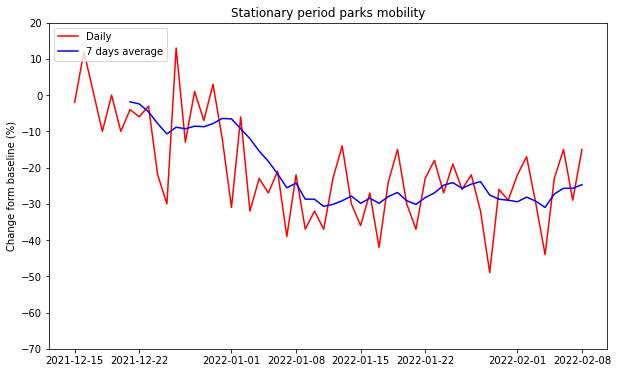

In [36]:
plt.figure(figsize = (10,6))
plt.title('Stationary period parks mobility')
plt.ylabel('Change form baseline (%)')
plt.ylim(-70,20)
plt.plot(df_NY_b.index,df_NY_b.parks, label = 'Daily', color = 'red')
plt.plot(df_NY_b.index,df_NY_b.parks.rolling(window = 7).mean(), label = '7 days average', color = 'blue')
plt.legend(loc="upper left")

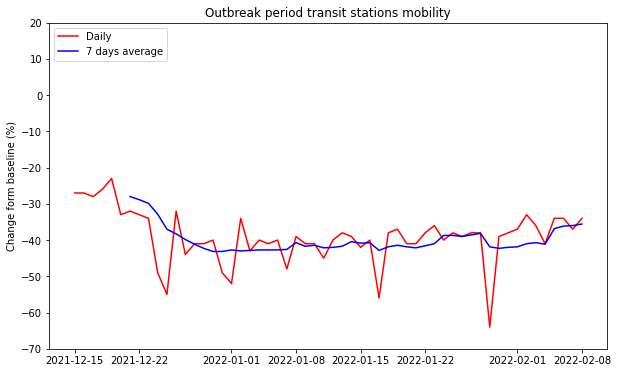

In [37]:
plt.figure(figsize = (10,6))
plt.title('Outbreak period transit stations mobility')
plt.ylabel('Change form baseline (%)')
plt.ylim(-70,20)
plt.plot(df_NY_b.index,df_NY_b.transit, label = 'Daily', color = 'red')
plt.plot(df_NY_b.index,df_NY_b.transit.rolling(window = 7).mean(), label = '7 days average', color = 'blue')
plt.legend(loc="upper left")

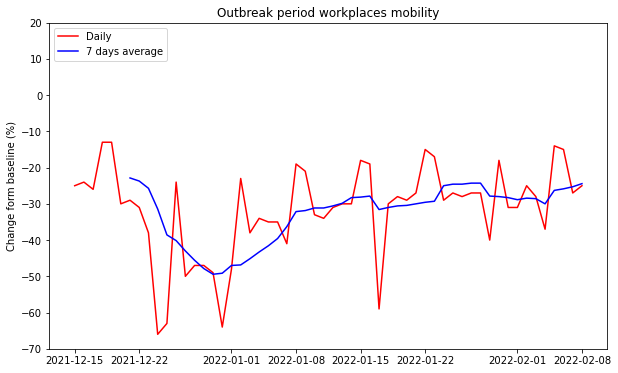

In [38]:
plt.figure(figsize = (10,6))
plt.title('Outbreak period workplaces mobility')
plt.ylabel('Change form baseline (%)')
plt.ylim(-70,20)
plt.plot(df_NY_b.index,df_NY_b.work, label = 'Daily', color = 'red')
plt.plot(df_NY_b.index,df_NY_b.work.rolling(window = 7).mean(), label = '7 days average', color = 'blue')
plt.legend(loc="upper left")

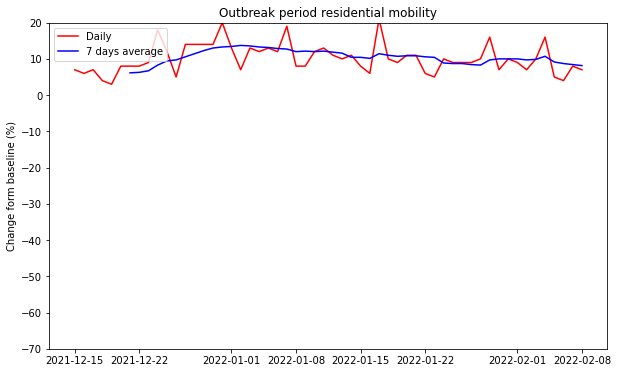

In [40]:
plt.figure(figsize = (10,6))
plt.title('Outbreak period residential mobility')
plt.ylabel('Change form baseline (%)')
plt.ylim(-70,20)
plt.plot(df_NY_b.index,df_NY_b.resident, label = 'Daily', color = 'red')
plt.plot(df_NY_b.index,df_NY_b.resident.rolling(window = 7).mean(), label = '7 days average', color = 'blue')
plt.legend(loc="upper left")

In [94]:
df_alabama = df_all[df_all['state']=='Alabama'][['retail','grocery','parks','transit','work','resident']].reset_index()
df_alabama = df_alabama.drop(columns='index')
df_alabama.head()

,retail,grocery,parks,transit,work,resident
0,5.0,2.0,39.0,7.0,2.0,-1.0
1,0.0,-2.0,-7.0,3.0,-1.0,1.0
2,3.0,0.0,17.0,7.0,-17.0,4.0
3,-4.0,-3.0,-11.0,-1.0,1.0,2.0
4,4.0,1.0,6.0,4.0,1.0,0.0


In [14]:
for i in df_alabama.columns:
    for j in range(1,8):
        df_alabama[f'{i}_t-{j}'] = df_alabama[i].shift(j).fillna(0)
df_alabama.head()

,retail,grocery,parks,transit,work,resident,retail_t-1,retail_t-2,retail_t-3,retail_t-4,...,work_t-5,work_t-6,work_t-7,resident_t-1,resident_t-2,resident_t-3,resident_t-4,resident_t-5,resident_t-6,resident_t-7
0,5.0,2.0,39.0,7.0,2.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-2.0,-7.0,3.0,-1.0,1.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,17.0,7.0,-17.0,4.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
3,-4.0,-3.0,-11.0,-1.0,1.0,2.0,3.0,0.0,5.0,0.0,...,0.0,0.0,0.0,4.0,1.0,-1.0,0.0,0.0,0.0,0.0
4,4.0,1.0,6.0,4.0,1.0,0.0,-4.0,3.0,0.0,5.0,...,0.0,0.0,0.0,2.0,4.0,1.0,-1.0,0.0,0.0,0.0


In [16]:
df_alabama.shape

(751, 48)

In [25]:
y = df_alabama.iloc[:, :1]
X = df_alabama.iloc[:, 6:13]

X_train=X.iloc[:600]
y_train=y.iloc[:600]
X_test=X.iloc[600:]
y_test=y.iloc[600:]
X_valid=X_train.iloc[480:]
y_valid=y_train.iloc[480:]

test_fold = np.zeros(751)
test_fold[:480] = -1
ps = PredefinedSplit(test_fold=test_fold)

In [45]:
rf = RandomForestRegressor(n_estimators=50, min_samples_split=8, min_samples_leaf=5)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
r2_score(y_test,y_pred)

0.19433069053479346